<div style='text-align: center;'>
<img src="images/math60082-banner.png" alt="image" width="80%" height="auto">
</div>

# Lecture 10: Quadrature

## Dr P. V. Johnson
## Department of Mathematics


Consider the well-known Black and Scholes (1973) partial differential equation for an option with an underlying
asset following geometric Brownian motion:
$$
\frac{\partial{V}}{\partial{t}} + \frac{1}{2} {\sigma}^2 S^2
\frac{\partial {^2V}}{\partial{S^2}} + (r-D_c) S
\frac{\partial{V}}{\partial{S}} - rV = 0,
$$
where $V(S,t)$ is the price of the derivative product, $S$ the
current value of the underlying asset, $t$ is time,  $T$ is the time to maturity
 $r$ the risk-free interest rate, $\sigma$ the
volatility of the underlying asset and $X$ is the exercise price of the option. 
$D_c$ is a continuous dividend yield which could, for example, be the foreign 
interest rate in a foreign exchange option.

Next make the following standard
transformations                
$$
x = log(S_0),
$$
$$
y = log(S_{T}).
$$
The final conditions for a European option expiring at time $T$
with  $V(y,T)$ are transformed in straightforward fashion; e.g. 
the payoff for a call option $V(S,T)  = \max(S_{T}-X,0)$ becomes
$$
\quad V(y,T) = \max(e^y-X,0). 
$$
The value of 
the option at time $t=0$ on an underlying asset  $S_0$  
has an  exact solution given by 
$$
V(x,0) = A (x) \int_{-\infty}^{\infty} B(x,y)V(y,T) \, dy,
$$
where, 
$$
A(x) = \frac{1}{\sqrt{2\sigma^2\pi T}} e^{-\frac12 kx-\frac18 
\sigma^2k^2 T - r T},
$$
and
$$
B(x,y) = e^{-\frac{(x-y)^2}{2\sigma^2 T} + \frac12 ky}
$$
and
$$
k = \frac{2(r-D_c)}{{\sigma}^2} -1.
$$

Let us go through an example solving this for a simple call option, before moving onto a barrier option. We will need to declare the functions $A$, $B$, a method for integrating and a method to return the value $V(x,0)$. Since integrations must work on fixed spaced grids, we also provide a function to do this. First include libraries:

In [1]:
import numpy
import scipy
import matplotlib.pyplot as plt

Numerically we also will have to bound the intergration, so we need a way to input these values. In fact the integration will look like
$$
V(x,0) = A (x) \int_\text{yMin}^\text{yMax} B(x,y)V(y,T) \, dy \approx A(x) \sum_j w_j B(x,y_j)V(y_j,T),
$$
where $w_j$ depends on the numerical integration scheme we choose.
By using this approximation we are assuming that the payoff is zero for $y<\text{yMin}$ and $y>\text{yMax}$, so in some cases the approximation can be improved here by using analytic results for the integrals either side
$$
V_\text{min}(x,0) = A (x) \int_{-\infty}^\text{yMin} B(x,y)V(y,T) \, dy,
$$
and
$$
V_\text{max}(x,0) = A (x) \int_\text{yMax}^\infty B(x,y)V(y,T) \, dy,
$$
such that
$$
V(x,0) = V_\text{min} + A (x) \int_\text{yMin}^\text{yMax} B(x,y)V(y,T) \, dy + V_\text{max},
$$

Input the function $A$ as given by the formula:

In [2]:
# the function A
def A_func( x, r, sigma, k, dt):
    return 1. / numpy.sqrt(2 * sigma*sigma*numpy.pi*dt) * numpy.exp(-0.5*k*x - 0.125*sigma*sigma*k*k*dt - r*dt)

Input the function $B$ as given by the formula:

In [3]:
# the function B
def B_func( x,  y,  sigma,  k,  dt):
    return numpy.exp(-(x - y)*(x - y) / (2.*sigma*sigma*dt) + 0.5 * k * y)

# Example - Call Option

We first set up the grid over the interval by applying a log transform
$$
x = log(S_0)
$$
and for the $y$ variable at $T$ for a call option we use
$$
y \in [ log(X) , log (X) + \xi \sigma T ] ,
$$
where $\xi$ is some grid scale factor set large enough to capture the value of the option.
After the variable $k$ is assigned, we can generate values of the integrand, $f_j$
$$
f_j = B(x,y_j) V(y_j,T) = B(x,y_j) (e^{y_j} -X)
$$
for our call option.

Then the value of the option can be found as
$$
V(x,0) = A(x) \frac{\text{yMax}-\text{yMin}}{3 n}\left( f_0 + 2\sum_{j=1}^{n/2} f_{2j} + 4\sum_{j=0}^{n/2} f_{2j+1}+ f_n \right)
$$

Now setup some model parameters:

In [4]:
S0 = 97.7402
X = 100.
r = 0.06
Dc = 0.02
sigma = 0.2
T = 1.

We need to setup the grid $y$ at the terminal time $t=T$:

In [5]:
N=500
xi=10.0
    
# now get value of x at time t=0
x = numpy.log(S0)
# and setup the vector y
y = numpy.linspace(numpy.log(X),numpy.log(X)+ 10*sigma*numpy.sqrt(T),N+1)
    

Now enter the values for $f_j$ as defined above

In [6]:

# variable k
kStar = 2.*(r - Dc) / sigma / sigma - 1.
           
# setup vectors to store option values, and integrand function
# these vectors must be the same size as the y vector
f = numpy.zeros(N+1)
    
for j in range(N+1):
    # note here that $y_j>\log(X)$ so the option is always exercised
    f[j] = B_func( x , y[j] , sigma , kStar , T ) * (numpy.exp(y[j]) - X)
    
# now use scipy to do a Simpsons rule integration
# first get the fixed space inbetween points in y
h = y[1] - y[0]
value = A_func(x, r, sigma, kStar, T )*scipy.integrate.simpson(y=f,dx=y[1]-y[0])
print("C(",S0,") = ", value) 

C( 97.7402 ) =  8.408408342731933


Now put this in a function so that we can investigate the convergence

In [7]:
def  callOption( S0, X, r, Dc, sigma, T, N, xi):
    # now get value of x at time t=0
    x = numpy.log(S0)
    # and setup the vector y
    y = numpy.linspace(numpy.log(X),numpy.log(X)+ 10*sigma*numpy.sqrt(T),N+1)
        
    # variable k
    kStar = 2.*(r - Dc) / sigma / sigma - 1.
            
    # setup vectors to store option values, and integrand function
    # these vectors must be the same size as the y vector
    f = numpy.zeros(N+1)
        
    for j in range(N+1):
        # note here that $y_j>\log(X)$ so the option is always exercised
        f[j] = B_func( x , y[j] , sigma , kStar , T ) * (numpy.exp(y[j]) - X)
        
    # now use scipy to do a Simpsons rule integration
    # first get the fixed space inbetween points in y
    h = y[1] - y[0]
    # then intergrate function f
    return A_func(x, r, sigma, kStar, T )*scipy.integrate.simpson(y=f,dx=y[1]-y[0])
    

And then we create our convergence table as usual to show what happens as $N\to\infty$.

In [8]:
S0 = 97.7402
X = 100.
r = 0.06
Dc = 0.02
sigma = 0.2
T = 1.
   
# Examine convergence of a call option using QUAD...
print("|         N|  V(S,0;N)|       R  | conv rate|")
print("|----------|----------|----------|----------|")

valueOld = 1.
diffOld=1.

ratio = 2

for k in range(0,8):
    n = int( 10* (ratio**k) )
    value = callOption(S0,X,r,Dc,sigma,T,n,10.)
    diff = value - valueOld
    R = diffOld/diff
    if k<2:
        convrate=numpy.nan
    else:
        convrate=numpy.log(R)/numpy.log(ratio)
    print(f"|{n:10d}|{value:10.3f}|{R:10.3f}|{convrate:10.3f}|")
    valueOld = value
    diffOld = diff
    

|         N|  V(S,0;N)|       R  | conv rate|
|----------|----------|----------|----------|
|        10|     8.699|     0.130|       nan|
|        20|     8.418|   -27.325|       nan|
|        40|     8.409|    32.556|     5.025|
|        80|     8.408|    18.334|     4.196|
|       160|     8.408|    16.487|     4.043|
|       320|     8.408|    16.117|     4.011|
|       640|     8.408|    16.029|     4.003|
|      1280|     8.408|    16.013|     4.001|


Now we can see the power of this method, since we use integration and the simpsons rule we are able to get 4th order convergence,
$$
V^N = V^\text{exact} + O\left(N^{-4}\right) ,
$$
and we could get even higher convergence by extrapolating these results!

## Example -- Up and Out Barrier Call Option

This is nice but we already have an analytic solution to this problem. How about something more complicated? The discretely observed up-and-out barrier call option is a problem that can't easily be solved with standard techniques such as Monte-Carlo or Lattice methods. However this problem is uniquely adaptable to quadrature methods, given that  we know at each observation time point $t_k$ the value of the function becomes zero, the region over which this happens can be split out and set to zero.

To see how to solve this method using quadrature, the best way is to first observe how the grid adapts to the problem through time. Consider an up and out barrier call option observed at equally spaced times $t_k=k\Delta t$ such that $$\Delta t = \frac{T}{K}.$$ The payoff for the option is given by
$$
V(S,T) = \max(S-X,0)
$$
and the condition at each observation point is that
$$
V(S,t_k) = 0 \text{ if } S>B \text{ for } k=0,1,\dots K-1 .
$$
At the terminal time, as before apply a log transform so that the $y$ variable at $T$ becomes
$$
y \in [ log(X) ,  log (X) + \xi \sigma T ] .
$$

Now for the $x$ grid, this is set at $t=t_{K-1}$, and we use the fact that $V$ is zero above the barrier to ignore any point above $S>B$, therefore
$$
x \in [  log(S_0) - \xi \sigma sqrt(T) , log(B) ] .
$$

The lower boundary here is calculated to be sufficiently small such that $B( log(S_0), y_\text{min} , t_k )V(y_\text{min},t_k) = 0 $ for $y<y_\text{min}$.

The grids follow this pattern through time until we arrive at the last step, at which point we will wish to calculate $x_0 =  log(S_0)$.

In [9]:
S0 = 97.7402
X = 100.
r = 0.06
Dc = 0.02
sigma = 0.2
T = 1.

# K is the number of observations
K=5

# B is the barrier
B=110.

# N is the number of nodes at each step
N=4

# grid scale
xi=1.
    
# first setup a time grid
t = numpy.linspace(0.0,T,num=K+1)

Now setup $y$ grid at $t_K=T$, and $x$ grid at $t_{K-1}$

In [10]:
y = numpy.linspace(numpy.log(X),numpy.log(X)+ xi*sigma*numpy.sqrt(t[K]),num=N+1)
x = numpy.linspace(numpy.log(S0)-xi*sigma*numpy.sqrt(t[K-1]),numpy.log(B),num=N+1)

And let's plot this out. We see the different colours correspond to the valuation carried out at the grid node.

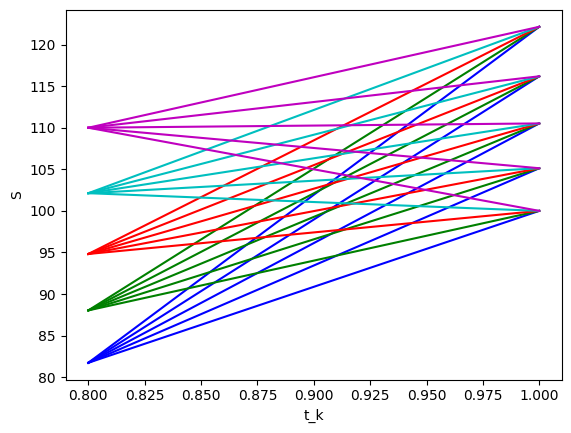

In [11]:
# colours
colours = ['b','g','r','c','m','y','k']
plt.xlabel("t_k")
plt.ylabel("S")
# plot the grid nodes on the final step
for i in range(N+1):
    nodeColour = colours[ i%7 ]
    for j in range(N+1):
        plot_line_x = [ t[K-1] ,t[K] ]
        plot_line_y = [ numpy.exp(x[i]) , numpy.exp(y[j]) ]
        plt.plot(plot_line_x,plot_line_y,color = nodeColour)

And now as we move backwards through time it looks like this:

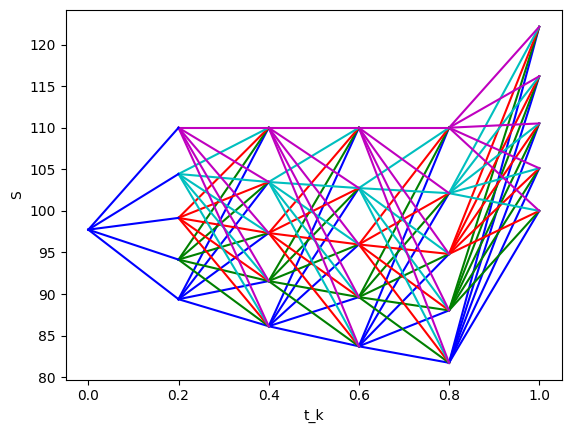

In [12]:
# colours
colours = ['b','g','r','c','m','y','k']
plt.xlabel("t_k")
plt.ylabel("S")

# setup grid nodes at final step
y = numpy.linspace(numpy.log(X),numpy.log(X)+ xi*sigma*numpy.sqrt(t[K]),num=N+1)
x = numpy.linspace(numpy.log(S0)-xi*sigma*numpy.sqrt(t[K-1]),numpy.log(B),num=N+1)
# plot the grid nodes on the final step
for i in range(N+1):
    nodeColour = colours[ i%7 ]
    for j in range(N+1):
        plot_line_x = [ t[K-1] ,t[K] ]
        plot_line_y = [ numpy.exp(x[i]) , numpy.exp(y[j]) ]
        plt.plot(plot_line_x,plot_line_y,color = nodeColour)
        
# to move backwards through grid, copy x values onto the "y" grid,
y = numpy.copy(x)

# now move back through time
for k in range(K-2,0,-1):
    # and the x grid at t=t_{k}, now using the barrier as the upper limit and S0 at the lower limit
    x = numpy.linspace(numpy.log(S0)-xi*sigma*numpy.sqrt(t[k]),numpy.log(B),num=N+1)

    # plot the grid nodes on the final step
    for i in range(N+1):
        nodeColour = colours[ i%7 ]
        for j in range(N+1):
            plot_line_x = [ t[k] ,t[k+1] ]
            plot_line_y = [ numpy.exp(x[i]) , numpy.exp(y[j]) ]
            plt.plot(plot_line_x,plot_line_y,color = nodeColour)
    # overwrite the y values with x
    y = numpy.copy(x)

# and at the final step, x = x0 at t=t_{0}, 
x = numpy.linspace(numpy.log(S0),numpy.log(S0),num=1)

for i in range( len(x) ):
    nodeColour = colours[ i%7 ]
    for j in range(N+1):
        plot_line_x = [ t[0] ,t[1] ]
        plot_line_y = [ numpy.exp(x[i]) , numpy.exp(y[j]) ]
        plt.plot(plot_line_x,plot_line_y,color = nodeColour)


Now all that need to be done compared to the code above, is to put in `vNew` and `vOld` to calculate the option values at each timestep as we would do with an explicit method.

In [13]:
# Black Scholes parameters
# K is the number of observations
# Barrier is the barrier
# N is the number of nodes at each step
# grid scale
def barrierCallOption(S0,X,r,Dc,sigma,T ,K,B,N,xi):

    # first setup a time grid
    t = numpy.linspace(0.0,T,num=K+1)
        
    # setup grid nodes at final step
    y = numpy.linspace(numpy.log(X),numpy.log(X)+ xi*sigma*numpy.sqrt(t[K]),num=N+1)
    x = numpy.linspace(numpy.log(S0)-xi*sigma*numpy.sqrt(t[K-1]),numpy.log(B),num=N+1)
    
    # store values for the option 
    vNew = numpy.zeros(N+1)
    vOld = numpy.zeros(N+1)
    
    for j in range(N+1):
        vOld[j] = numpy.exp(y[j]) - X
    
    # calculate the option values at x_i
    for i in range(N+1):
        # variable k
        kStar = 2.*(r-Dc) / sigma / sigma - 1.;

        # setup vectors to store option values, and integrand function
        # these vectors must be the same size as the y vector
        f = numpy.zeros(N+1)
            
        for j in range(N+1):
            # note here that $y_j>\log(X)$ so the option is always exercised
            f[j] = B_func( x[i] , y[j] , sigma , kStar , T - t[K-1] ) * vOld[j]
            
        # now use scipy to do a Simpsons rule integration
        # first get the fixed space inbetween points in y
        h = y[1] - y[0]
        # then intergrate function f
        vNew[i] = A_func(x[i], r, sigma, kStar, T - t[K-1] )*scipy.integrate.simpson(y=f,dx=y[1]-y[0])       
    
    # overwrite the y values with x
    y = numpy.copy(x);
    vOld = numpy.copy(vNew);
    
    # now move back through time
    for k in range(K-2,0,-1):
        # and the x grid at t=t_{k}, now using the barrier as the upper limit and S0 at the lower limit
        x = numpy.linspace(numpy.log(S0)-xi*sigma*numpy.sqrt(t[k]),numpy.log(B),num=N+1)
        
        # calculate value at every grid node at t[k]
        for i in range(N+1):
            # variable k
            kStar = 2.*(r-Dc) / sigma / sigma - 1.;

            # setup vectors to store option values, and integrand function
            # these vectors must be the same size as the y vector
            f = numpy.zeros(N+1)
                
            for j in range(N+1):
                # note here that $y_j>\log(X)$ so the option is always exercised
                f[j] = B_func( x[i] , y[j] , sigma , kStar , t[k+1]-t[k] ) * vOld[j]
                
            # now use scipy to do a Simpsons rule integration
            # first get the fixed space inbetween points in y
            h = y[1] - y[0]
            # then intergrate function f
            vNew[i] = A_func(x[i], r, sigma, kStar, t[k+1]-t[k] )*scipy.integrate.simpson(y=f,dx=y[1]-y[0])       
        

        # overwrite the y values with x
        y = numpy.copy(x)
        # and old with new
        vOld = numpy.copy(vNew)
    
    # and at the final step, x = x0 at t=t_{0}, 
    x = numpy.linspace(numpy.log(S0),numpy.log(S0),num=1)
    # variable k
    kStar = 2.*(r-Dc) / sigma / sigma - 1.;

    # setup vectors to store option values, and integrand function
    # these vectors must be the same size as the y vector
    f = numpy.zeros(N+1)
        
    for j in range(N+1):
        # note here that $y_j>\log(X)$ so the option is always exercised
        f[j] = B_func( x[0] , y[j] , sigma , kStar , t[1]-t[0] ) * vOld[j]
        
    # now use scipy to do a Simpsons rule integration
    # first get the fixed space inbetween points in y
    h = y[1] - y[0]
    # then intergrate function f
    return A_func(x[0], r, sigma, kStar, t[1]-t[0] )*scipy.integrate.simpson(y=f,dx=y[1]-y[0])
    

So now we can examine the convergence for the up-and-out Barrier call option using QUAD:

In [15]:
# BS parameters
S0 = 97.7402
X = 100.
r = 0.06
Dc = 0.02
sigma = 0.2
T = 1.

# number of observations
K=5

# B is the barrier
B=110.
    
   
# Examine convergence of a call option using QUAD...
print("|         N|  V(S,0;N)|       R  | conv rate|")
print("|----------|----------|----------|----------|")

valueOld = 1.
diffOld=1.

ratio = 2

for k in range(0,8):
    n = int( 10* (ratio**k) )
    value = barrierCallOption(S0,X,r,Dc,sigma,T,K,B,n,10.)
    diff = value - valueOld
    R = diffOld/diff
    if k<3:
        convrate=numpy.nan
    else:
        convrate=numpy.log(R)/numpy.log(ratio)
    print(f"|{n:10d}|{value:10.6f}|{R:10.3f}|{convrate:10.3f}|")
    valueOld = value
    diffOld = diff

|         N|  V(S,0;N)|       R  | conv rate|
|----------|----------|----------|----------|
|        10|  0.784989|    -4.651|       nan|
|        20|  1.324817|    -0.398|       nan|
|        40|  1.288179|   -14.734|       nan|
|        80|  1.286968|    30.247|     4.919|
|       160|  1.286898|    17.408|     4.122|
|       320|  1.286894|    16.321|     4.029|
|       640|  1.286893|    16.078|     4.007|
|      1280|  1.286893|    16.019|     4.002|


Again using integration and the simpsons rule, we are able to get 4th order convergence,
$$
V^N = V^\text{exact} + O\left(N^{-4}\right) .
$$
This is because we avoid any errors that arise from discontinuities in the payoff by splitting the integral. The method is tricky to setup and harder to generalise than other methods, but it is extremely powerful none the less.